In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()


In [29]:
def bake_model():
    lstm_params = [{
        'units': 64,
        'dropout': 0.6,
        'recurrent_dropout': 0.6,
        'batch_input_shape': (None, 64, 8),
        },

    ]

    optimizer_params = {
        'learning_rate': 0.001,  
        'beta1': 0.9, 
        'beta2': 0.999, 
        'epsilon': 1e-08
    }

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [37]:
def weights(obj, ):
    return [x for x in vars(obj).keys() if   'weight' in x]
# LSTM weights...
# ['_trainable_weights', '_non_trainable_weights', '_initial_weights']

#print(model._layers[1]._initial_weights) # <- None
# print([weights(x) for x in
#    model._layers[1]._layers])
# [['_trainable_weights', '_non_trainable_weights', '_initial_weights'], [], []]

#[x.shape for x in model._layers[1]._layers[0]._trainable_weights]
# [TensorShape([Dimension(8), Dimension(256)]),
# TensorShape([Dimension(64), Dimension(256)]),
# TensorShape([Dimension(256)])]

# model._layers[1]._layers[0]._initial_weights  # <--None, hmm..

for i in range(3):
    model = bake_model()
    print([x[0, :5]  for x in model._layers[1]._layers[0]._trainable_weights[:2]])
    print(model._layers[1]._layers[0]._trainable_weights[2])

[<tf.Tensor: id=1324, shape=(5,), dtype=float32, numpy=
array([-0.03004508,  0.14491767,  0.04427765,  0.08059219,  0.03595215],
      dtype=float32)>, <tf.Tensor: id=1329, shape=(5,), dtype=float32, numpy=
array([ 0.11298072,  0.0676304 ,  0.02081808,  0.02089654, -0.01962803],
      dtype=float32)>]
<tf.Variable 'lstm_1/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.

In [19]:
# Hmm so part of that looks random each time ^^ 
# but that third element doesnt look random.

In [43]:
vars(model._layers[1]._layers[2])

{'_non_append_mutation': False,
 '_external_modification': False,
 '_self_trainable': True,
 '_self_extra_variables': [],
 '_storage': [InputSpec(shape=[None, 64], ndim=2),
  InputSpec(shape=[None, 64], ndim=2)],
 '_last_wrapped_list_snapshot': [InputSpec(shape=[None, 64], ndim=2),
  InputSpec(shape=[None, 64], ndim=2)],
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

In [44]:
model._layers[1].kernel_initializer

In [47]:
# Ok. so I see this ^ GlorotUniform at 
# https://www.tensorflow.org/api_docs/python/tf/keras/initializers
#  ( which is aka Xavier Uniform)
# So for sure it seems its worth considering this as another hyper parameter
# So since I've been using this default ^, I want to try the 
# Xavier Normal option noted here, https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/
# 


In [55]:
# Working dir... for new model
save_dir = 'history'
ts = mu.quickts(); print('starting,', ts)

workdir = f'{save_dir}/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')

starting, 2020-01-12T225750Z
Made new workdir, history/2020-01-12T225750Z


In [56]:
def bake_model():
    lstm_params = [{
        'units': 64,
        'dropout': 0.6,
        'recurrent_dropout': 0.6,
        'batch_input_shape': (None, 64, 8),
        'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                               #tf.initializers.he_normal()
        },

    ]

    optimizer_params = {
        'learning_rate': 0.001,  
        'beta1': 0.9, 
        'beta2': 0.999, 
        'epsilon': 1e-08
    }

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [57]:
model = bake_model()

In [64]:
BATCH_SIZE = 32
EPOCHS = 1
# Use datasets from 
# 2019-12-25.ipynb
# 
# train ... new datasets, ...
datadir = 'history/2019-12-22T174803Z'
# train_loc = f'{datadir}/train_balanced.h5'
test_loc = f'{datadir}/test_balanced.h5'
train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'
print(mu.h5_keys(train_shuff_loc))
print(mu.h5_keys(test_loc))

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')


['X', 'Ylabels']
['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [66]:
%%time

model = mu.load_model(f'{workdir}/00000__unfitted_model.h5')

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
#with ipdb.launch_ipdb_on_exception():
mu.do_train( 
        model,
        dataset_batches,
        k=size,
        epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)


0it [00:00, ?it/s]
1it [00:00,  2.00it/s]
2it [00:00,  2.18it/s]
3it [00:01,  2.32it/s]
4it [00:01,  2.44it/s]
5it [00:01,  2.56it/s]
6it [00:02,  2.64it/s]
7it [00:02,  2.71it/s]
8it [00:02,  2.74it/s]
9it [00:03,  2.47it/s]
10it [00:03,  2.59it/s]
11it [00:04,  2.67it/s]
12it [00:04,  2.74it/s]
13it [00:04,  2.76it/s]
14it [00:05,  2.78it/s]
15it [00:05,  2.80it/s]
16it [00:05,  2.83it/s]
17it [00:06,  2.83it/s]
18it [00:06,  2.54it/s]
19it [00:07,  2.63it/s]
20it [00:07,  2.71it/s]
21it [00:07,  2.75it/s]
22it [00:08,  2.77it/s]
23it [00:08,  2.78it/s]
24it [00:08,  2.80it/s]
25it [00:09,  2.80it/s]
26it [00:09,  2.80it/s]
27it [00:10,  2.52it/s]
28it [00:10,  2.61it/s]
29it [00:10,  2.68it/s]
30it [00:11,  2.72it/s]
31it [00:11,  2.72it/s]
32it [00:11,  2.78it/s]
33it [00:12,  2.80it/s]
34it [00:12,  2.80it/s]
35it [00:13,  2.51it/s]
36it [00:13,  2.59it/s]
37it [00:13,  2.65it/s]
38it [00:14,  2.69it/s]
39it [00:14,  2.73it/s]
40it [00:14,  2.75it/s]
41it [00:15,  2.76it/s]
42it 

296it [01:52,  1.90it/s]
297it [01:52,  1.84it/s]
298it [01:53,  1.83it/s]
299it [01:54,  1.80it/s]
300it [01:54,  1.80it/s]
301it [01:54,  2.01it/s]
302it [01:55,  2.19it/s]
303it [01:55,  2.34it/s]
304it [01:56,  2.47it/s]
305it [01:56,  2.57it/s]
306it [01:56,  2.63it/s]
307it [01:57,  2.67it/s]
308it [01:57,  2.71it/s]
309it [01:57,  2.46it/s]
310it [01:58,  2.56it/s]
311it [01:58,  2.64it/s]
312it [01:59,  2.70it/s]
313it [01:59,  2.74it/s]
314it [01:59,  2.76it/s]
315it [02:00,  2.78it/s]
316it [02:00,  2.81it/s]
317it [02:00,  2.52it/s]
318it [02:01,  2.59it/s]
319it [02:01,  2.66it/s]
320it [02:01,  2.71it/s]
321it [02:02,  2.74it/s]
322it [02:02,  2.77it/s]
323it [02:03,  2.77it/s]
324it [02:03,  2.76it/s]
325it [02:03,  2.48it/s]
326it [02:04,  2.55it/s]
327it [02:04,  2.61it/s]
328it [02:04,  2.68it/s]
329it [02:05,  2.72it/s]
330it [02:05,  2.73it/s]
331it [02:06,  2.73it/s]
332it [02:06,  2.73it/s]
333it [02:06,  2.75it/s]
334it [02:07,  2.48it/s]
335it [02:07,  2.57it/s]


588it [03:43,  2.73it/s]
589it [03:43,  2.75it/s]
590it [03:43,  2.46it/s]
591it [03:44,  2.53it/s]
592it [03:44,  2.57it/s]
593it [03:45,  2.61it/s]
594it [03:45,  2.65it/s]
595it [03:45,  2.70it/s]
596it [03:46,  2.70it/s]
597it [03:46,  2.73it/s]
598it [03:46,  2.73it/s]
599it [03:47,  2.48it/s]
600it [03:47,  2.58it/s]
601it [03:48,  2.62it/s]
602it [03:48,  2.67it/s]
603it [03:48,  2.69it/s]
604it [03:49,  2.68it/s]
605it [03:49,  2.70it/s]
606it [03:49,  2.72it/s]
607it [03:50,  2.46it/s]
608it [03:50,  2.55it/s]
609it [03:51,  2.57it/s]
610it [03:51,  2.61it/s]
611it [03:51,  2.64it/s]
612it [03:52,  2.67it/s]
613it [03:52,  2.70it/s]
614it [03:52,  2.72it/s]
615it [03:53,  2.46it/s]
616it [03:53,  2.56it/s]
617it [03:54,  2.60it/s]
618it [03:54,  2.67it/s]
619it [03:54,  2.72it/s]
620it [03:55,  2.75it/s]
621it [03:55,  2.75it/s]
622it [03:55,  2.78it/s]
623it [03:56,  2.80it/s]
624it [03:56,  2.52it/s]
625it [03:57,  2.58it/s]
626it [03:57,  2.66it/s]
627it [03:57,  2.72it/s]


880it [05:34,  2.69it/s]
881it [05:34,  2.71it/s]
882it [05:34,  2.73it/s]
883it [05:35,  2.46it/s]
884it [05:35,  2.54it/s]
885it [05:36,  2.59it/s]
886it [05:36,  2.64it/s]
887it [05:36,  2.67it/s]
888it [05:37,  2.70it/s]
889it [05:37,  2.72it/s]
890it [05:37,  2.73it/s]
891it [05:38,  2.71it/s]
892it [05:38,  2.42it/s]
893it [05:39,  2.49it/s]
894it [05:39,  2.54it/s]
895it [05:39,  2.58it/s]
896it [05:40,  2.61it/s]
897it [05:40,  2.62it/s]
898it [05:41,  2.63it/s]
899it [05:41,  2.64it/s]
900it [05:41,  2.39it/s]
901it [05:42,  2.45it/s]
902it [05:42,  2.52it/s]
903it [05:43,  2.59it/s]
904it [05:43,  2.65it/s]
905it [05:43,  2.67it/s]
906it [05:44,  2.70it/s]
907it [05:44,  2.71it/s]
908it [05:45,  2.42it/s]
909it [05:45,  2.49it/s]
910it [05:45,  2.54it/s]
911it [05:46,  2.59it/s]
912it [05:46,  2.61it/s]
913it [05:46,  2.64it/s]
914it [05:47,  2.66it/s]
915it [05:47,  2.67it/s]
916it [05:47,  2.72it/s]
917it [05:48,  2.46it/s]
918it [05:48,  2.55it/s]
919it [05:49,  2.62it/s]


CPU times: user 6min 53s, sys: 986 ms, total: 6min 54s
Wall time: 6min 55s


In [69]:
print(list(np.arange(0, 1100, 50)))

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050]


In [70]:
epoch = 0
for batch in tqdm(list(np.arange(0, 1100, 50))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))


100%|██████████| 22/22 [00:00<00:00, 14902.24it/s]

history/2020-01-12T225750Z/epoch_000_batch_00000_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00050_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00100_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00150_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00200_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00250_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00300_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00350_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00400_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00450_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00500_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00550_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00600_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00650_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00700_model.h5 True
history/2020-01-12T225750Z/epoch_000_batch_00750_model.


  0%|          | 0/22 [00:00<?, ?it/s]

starting validation 2020-01-12T233154Z
history/2020-01-12T225750Z/epoch_000_batch_00000_model.h5 True



  5%|▍         | 1/22 [05:42<1:59:52, 342.52s/it]

history/2020-01-12T225750Z/epoch_000_batch_00050_model.h5 True



  9%|▉         | 2/22 [11:22<1:53:55, 341.79s/it]

history/2020-01-12T225750Z/epoch_000_batch_00100_model.h5 True



 14%|█▎        | 3/22 [17:03<1:48:06, 341.40s/it]

history/2020-01-12T225750Z/epoch_000_batch_00150_model.h5 True



 18%|█▊        | 4/22 [22:47<1:42:43, 342.41s/it]

history/2020-01-12T225750Z/epoch_000_batch_00200_model.h5 True



 23%|██▎       | 5/22 [28:32<1:37:12, 343.06s/it]

history/2020-01-12T225750Z/epoch_000_batch_00250_model.h5 True



 27%|██▋       | 6/22 [34:33<1:32:56, 348.54s/it]

history/2020-01-12T225750Z/epoch_000_batch_00300_model.h5 True



 32%|███▏      | 7/22 [40:20<1:27:01, 348.09s/it]

history/2020-01-12T225750Z/epoch_000_batch_00350_model.h5 True



 36%|███▋      | 8/22 [46:01<1:20:42, 345.87s/it]

history/2020-01-12T225750Z/epoch_000_batch_00400_model.h5 True



 41%|████      | 9/22 [51:46<1:14:51, 345.52s/it]

history/2020-01-12T225750Z/epoch_000_batch_00450_model.h5 True



 45%|████▌     | 10/22 [57:32<1:09:08, 345.69s/it]

history/2020-01-12T225750Z/epoch_000_batch_00500_model.h5 True



 50%|█████     | 11/22 [1:03:13<1:03:08, 344.43s/it]

history/2020-01-12T225750Z/epoch_000_batch_00550_model.h5 True



 55%|█████▍    | 12/22 [1:08:56<57:18, 343.86s/it]  

history/2020-01-12T225750Z/epoch_000_batch_00600_model.h5 True



 59%|█████▉    | 13/22 [1:14:40<51:34, 343.88s/it]

history/2020-01-12T225750Z/epoch_000_batch_00650_model.h5 True



 64%|██████▎   | 14/22 [1:20:25<45:53, 344.19s/it]

history/2020-01-12T225750Z/epoch_000_batch_00700_model.h5 True



 68%|██████▊   | 15/22 [1:26:10<40:12, 344.59s/it]

history/2020-01-12T225750Z/epoch_000_batch_00750_model.h5 True



 73%|███████▎  | 16/22 [1:31:51<34:21, 343.58s/it]

history/2020-01-12T225750Z/epoch_000_batch_00800_model.h5 True



 77%|███████▋  | 17/22 [1:37:32<28:34, 342.81s/it]

history/2020-01-12T225750Z/epoch_000_batch_00850_model.h5 True



 82%|████████▏ | 18/22 [1:43:14<22:50, 342.55s/it]

history/2020-01-12T225750Z/epoch_000_batch_00900_model.h5 True



 86%|████████▋ | 19/22 [1:48:54<17:05, 341.72s/it]

history/2020-01-12T225750Z/epoch_000_batch_00950_model.h5 True



 91%|█████████ | 20/22 [1:54:35<11:23, 341.53s/it]

history/2020-01-12T225750Z/epoch_000_batch_01000_model.h5 True



 95%|█████████▌| 21/22 [2:00:17<05:41, 341.72s/it]

history/2020-01-12T225750Z/epoch_000_batch_01050_model.h5 True



100%|██████████| 22/22 [2:06:00<00:00, 343.64s/it]

done validation 2020-01-13T013754Z


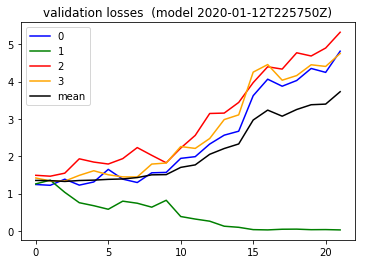

In [71]:
print('starting validation', mu.quickts())
batch_losses_vec = []

epoch = 0
for batch in tqdm(list(np.arange(0, 1100, 50))):
    step = batch
    prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                           f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mv.json_save({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []
#for step in np.arange(0, 1068, 10):
# [2.8359528, 0.45356295, 1.7049086, 4.099845]

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        